 # Apps Analysis

 ## 0. Data preprocessing

In [1]:
# Load library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from datetime import datetime
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as stm
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from statsmodels.stats.mediation import Mediation

# Manage warnings
pd.set_option('mode.chained_assignment', None)

# Import excel files
Data_1 = pd.read_excel(r'./Data_1.xlsx')
Data_2 = pd.read_excel(r'./Data_2.xlsx')
Data_3 = pd.read_excel(r'./Data_3.xlsx')
Data_4 = pd.read_excel(r'./Data_4.xlsx')
Personality = pd.read_excel(r'./Part_Personality.xlsx')

# Create a new ID column common to all datasets
for i in [Data_1, Data_2, Data_3, Data_4, Personality]:
    # concatenate 'Probanden_ID' and 'lfdn' to create a new unique variable
    # which identify the combination participant-app
    i['Probanden_ID__lfdn'] = i.Probanden_ID.astype(str) + '__' + \
                                  i.lfdn.astype(str)

# Create a new ID column which uniquely identify observations
# on Data_1, Data_2, Data_3, Data_4

# (PS. There are persons with the same initials and apps number
# so the progressive number is necessary)
for i in [Data_1, Data_2, Data_3, Data_4]:
    # concatenate 'Probanden_ID', 'lfdn' and 'AppNr' to create a new variable
    # which identify uniquely each observations
    i['Probanden_ID__lfdn__AppNr'] = i.Probanden_ID.astype(str) + '__' + \
                                     i.lfdn.astype(str) + '__' + \
                                     i.AppNr.astype(str)
    # delete redundant columns
    i.drop(['AppNr', 'lfdn', 'Probanden_ID'], axis=1, inplace=True)

# Check if V1 is the same in all 4 datasets for the combination
# participant + progressive number + app number

# list of dataframes with only the columns under investigation
dataframe_list = [Data_1[['Probanden_ID__lfdn__AppNr', 'V1']],
                  Data_2[['Probanden_ID__lfdn__AppNr', 'V1']],
                  Data_3[['Probanden_ID__lfdn__AppNr', 'V1']],
                  Data_4[['Probanden_ID__lfdn__AppNr', 'V1']]]

# reduce cumulatively compute a function on a list and return the result
V1_merge = reduce(lambda left, right: pd.merge(left, right,
                                               on='Probanden_ID__lfdn__AppNr'),
                  dataframe_list)

# Check all columns against the first column using 'eq'
V1_merge = V1_merge.fillna('-')
# 'all' make sure that all the value along the columns are true
# if sum equal to number rows then V1 is the same for all datasets
sum(V1_merge.filter(like='V1').eq(V1_merge.iloc[:, 1],
                                  axis=0).all(axis=1)) == Data_1.shape[0]

# Since they are all the same drop V1 from other datasets
for i in [Data_2, Data_3, Data_4]:
    i.drop('V1', axis=1, inplace=True)

# Rename cols before merging adding the number of the interview
# which is refering too
for num, data in enumerate([Data_1, Data_2, Data_3, Data_4]):
    for col_name in ['Datum', 'Interviewer', 'V4', 'V5', 'V6', 'V12',
                     'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23']:
        if any(data.columns == col_name):
            data.rename(columns={col_name: col_name +
                                 '_' + str(num + 1) +
                                 '_Interview'}, inplace=True)

# Merge datasets
for i in [Data_2, Data_3, Data_4]:
    i.drop('Probanden_ID__lfdn', axis=1, inplace=True)

dataframe_list = [Data_1, Data_2, Data_3, Data_4]

Apps = reduce(lambda left, right: pd.merge(left, right,
                                           on='Probanden_ID__lfdn__AppNr'),
              dataframe_list)

# Reorder columns
col = ['Probanden_ID__lfdn__AppNr', 'Probanden_ID__lfdn', 'Datum_1_Interview',
       'Datum_2_Interview', 'Datum_3_Interview', 'Datum_4_Interview',
       'Interviewer_1_Interview', 'Interviewer_2_Interview',
       'Interviewer_3_Interview', 'Interviewer_4_Interview', 'V1',
       'V01', 'V2', 'V3', 'V4_1_Interview', 'V4_2_Interview', 'V4_3_Interview',
       'V4_4_Interview', 'V5_1_Interview', 'V5_2_Interview', 'V5_3_Interview',
       'V5_4_Interview', 'V6_1_Interview', 'V6_2_Interview', 'V6_3_Interview',
       'V6_4_Interview', 'V7', 'V8', 'V9', 'V10', 'V11', 'Kombi',
       'V12_1_Interview', 'V12_2_Interview', 'V12_3_Interview',
       'V12_4_Interview', 'V13', 'V14', 'V17_2_Interview',
       'V17_3_Interview', 'V17_4_Interview', 'V18_2_Interview',
       'V18_3_Interview', 'V18_4_Interview', 'V19_2_Interview',
       'V19_3_Interview', 'V19_4_Interview', 'V20_2_Interview',
       'V20_3_Interview', 'V20_4_Interview', 'V21_2_Interview',
       'V21_3_Interview', 'V21_4_Interview', 'V22_2_Interview',
       'V23_2_Interview']

Apps = Apps[col]

# Calculate the percentage of missing for each row
# delete the row with high number of missing values(>80%)
values_over_rows = Apps.apply(lambda x: x.count(), axis=1)
Apps['Miss_row_%'] = 100 - values_over_rows/len(Apps.columns)*100
Apps = Apps[Apps['Miss_row_%'] < 80]

# Calculate the percentage of missing for each columns
# delete the columns with high number of missing values (>80%)
miss_cols_pct = pd.DataFrame(100-(Apps.apply(lambda x: x.count(), axis=0) /
                                  Apps.shape[0])*100)
col_del = list(miss_cols_pct[miss_cols_pct[0] > 80].index)  # V8, V9, Kombi
Apps.drop(col_del, axis=1, inplace=True)

# Format date
# Datum_1 filter out the date with a point between them
typo_row_index = []
typo_date = []

for row in list(Apps.index):
    # convert date on the format '03.01.2018'
    if len(str(Apps.loc[row, 'Datum_1_Interview'])) == 10:
        Apps.loc[row, 'Datum_1_Interview'] = \
            datetime.strptime(Apps.loc[row, 'Datum_1_Interview'],
                              '%d.%m.%Y')
    # convert date on the format '43037'
    elif len(str(Apps.loc[row, 'Datum_1_Interview'])) == 5:
        Apps.loc[row, 'Datum_1_Interview'] = \
            datetime.fromordinal(datetime(1900, 1, 1).toordinal() +
                                 int(Apps.loc[row, 'Datum_1_Interview']) - 2)
    elif pd.isna(Apps.loc[row, 'Datum_1_Interview']):
        pass  # do nothing
    else:  # write down the typos
        typo_row_index.append(row)
        typo_date.append(Apps.loc[row, 'Datum_1_Interview'])

# Adjust for typos
np.unique(typo_date)
for row in typo_row_index:
    Apps.loc[row, 'Datum_1_Interview'] = datetime(2017, 12, 20)

# Adjst date_2_interview
typo_row_index = []
typo_date = []

for row in list(Apps.index):
    # convert date on the format '03.01.2018'
    if len(str(Apps.loc[row, 'Datum_2_Interview'])) == 10:
        Apps.loc[row, 'Datum_2_Interview'] = \
            datetime.strptime(Apps.loc[row, 'Datum_2_Interview'],
                              '%d.%m.%Y')
    # if already in timestamp format
    elif isinstance(Apps.loc[row, 'Datum_2_Interview'], datetime):
        pass  # do nothing
    elif pd.isna(Apps.loc[row, 'Datum_2_Interview']):
        pass  # do nothing
    else:  # write down the typos
        typo_row_index.append(row)
        typo_date.append(Apps.loc[row, 'Datum_2_Interview'])

# Adjst for date_3_interview
typo_row_index = []
typo_date = []

for row in list(Apps.index):
    # If it is already an instance of datetime do nothing
    if isinstance(Apps.loc[row, 'Datum_3_Interview'], datetime):
        pass
    # convert date on the format '03.01.2018'
    elif len(str(Apps.loc[row, 'Datum_3_Interview'])) == 10 and \
            Apps.loc[row, 'Datum_3_Interview'].find('.') > 0:
        Apps.loc[row, 'Datum_3_Interview'] = \
            datetime.strptime(Apps.loc[row, 'Datum_3_Interview'],
                              '%d.%m.%Y')
    # convert date on the format '17/05/2018'
    elif len(str(Apps.loc[row, 'Datum_3_Interview'])) == 10 and \
            Apps.loc[row, 'Datum_3_Interview'].find('/') > 0:
        Apps.loc[row, 'Datum_3_Interview'] = \
            datetime.strptime(Apps.loc[row, 'Datum_3_Interview'],
                              '%d/%m/%Y')
    # If it is already in timestamp pass
    elif pd.isna(Apps.loc[row, 'Datum_3_Interview']):
        pass  # do nothing
    else:  # write down any other typos
        typo_row_index.append(row)
        typo_date.append(Apps.loc[row, 'Datum_3_Interview'])

# Adjst for date_4_interview
typo_row_index = []
typo_date = []

for row in list(Apps.index):
    # It is already an instance of datetime pass
    if isinstance(Apps.loc[row, 'Datum_4_Interview'], datetime):
        pass
    # convert date on the format '03.01.2018'
    elif len(str(Apps.loc[row, 'Datum_4_Interview'])) == 10 and \
            Apps.loc[row, 'Datum_4_Interview'].find('.') > 0:
        Apps.loc[row, 'Datum_4_Interview'] = \
            datetime.strptime(Apps.loc[row, 'Datum_4_Interview'],
                              '%d.%m.%Y')
    # convert date on the format '17/05/2018'
    elif len(str(Apps.loc[row, 'Datum_4_Interview'])) == 10 and \
            Apps.loc[row, 'Datum_4_Interview'].find('/') > 0:
        Apps.loc[row, 'Datum_4_Interview'] = \
            datetime.strptime(Apps.loc[row, 'Datum_4_Interview'],
                              '%d/%m/%Y')
    # If it is missing
    elif pd.isna(Apps.loc[row, 'Datum_4_Interview']):
        pass
    else:  # write down the typos
        typo_row_index.append(row)
        typo_date.append(Apps.loc[row, 'Datum_4_Interview'])


# Check if the interviews are progressive
Apps['Days_Between_2_and_1_Interview'] = Apps['Datum_2_Interview'] - \
                                                Apps['Datum_1_Interview']

# correct the typo with year 2108 in Datum_2_Interview
Apps.loc[Apps['Datum_2_Interview'] > datetime(2020, 1, 1),
         'Datum_2_Interview'] = datetime(2018, 4, 11)

# Update calculation
Apps['Days_Between_2_and_1_Interview'] = Apps['Datum_2_Interview'] - \
                                                Apps['Datum_1_Interview']

# Transform the calculation into numbers of days
Apps['Days_Between_2_and_1_Interview'] = \
        Apps['Days_Between_2_and_1_Interview'].apply(lambda x:
                                                     x.total_seconds() /
                                                     60/60/24)

# Difference between 3 and 2 interview
Apps['Days_Between_3_and_2_Interview'] = Apps['Datum_3_Interview'] - \
                                                Apps['Datum_2_Interview']

# Spot typos
pd.unique(Apps.loc[Apps['Datum_3_Interview'] > datetime(2020, 1, 1),
                   'Datum_3_Interview'])
# (2918, 2, 3, 0, 0)
Apps.loc[Apps['Datum_3_Interview'] > datetime(2500, 1, 1),
         'Datum_3_Interview'] = datetime(2018, 2, 3)

# (2020, 5, 17, 0, 0)
Apps.loc[Apps['Datum_3_Interview'] > datetime(2020, 1, 1),
         'Datum_3_Interview'] = datetime(2018, 5, 17)

# Did we have collection of data also during the 2019?
Apps.loc[Apps['Datum_3_Interview'] > datetime(2019, 1, 1),
         'Datum_3_Interview'] = datetime(2018, 5, 17)

Apps['Days_Between_3_and_2_Interview'] = Apps['Datum_3_Interview'] - \
                                                Apps['Datum_2_Interview']

# Into numbers of days
Apps['Days_Between_3_and_2_Interview'] = \
        Apps['Days_Between_3_and_2_Interview'].apply(lambda x:
                                                     x.total_seconds() /
                                                     60/60/24)

# Difference between 4 and 3 interview
Apps['Days_Between_4_and_3_Interview'] = Apps['Datum_4_Interview'] - \
                                                Apps['Datum_3_Interview']

# Spot typos
pd.unique(Apps.loc[Apps['Datum_4_Interview'] > datetime(2020, 1, 1),
                   'Datum_4_Interview'])

# datetime(3018, 3, 4, 0, 0)
Apps.loc[Apps['Datum_4_Interview'] > datetime(2500, 1, 1),
         'Datum_4_Interview'] = datetime(2018, 3, 4)

# Update calculation
Apps['Days_Between_4_and_3_Interview'] = Apps['Datum_4_Interview'] - \
                                                Apps['Datum_3_Interview']

# Find the date after 01/01/2019
np.unique(Apps.loc[Apps['Datum_4_Interview'] > datetime(2019, 1, 1),
          'Datum_4_Interview'])

# Change 2019-07-09 to 2018-07-09
Apps.loc[Apps['Datum_4_Interview'] > datetime(2019, 1, 1),
         'Datum_4_Interview'] = datetime(2018, 7, 9)

# Update the calcualtion
Apps['Days_Between_4_and_3_Interview'] = Apps['Datum_4_Interview'] - \
                                                Apps['Datum_3_Interview']

# Trasform the calculation into numbers of days
Apps['Days_Between_4_and_3_Interview'] = \
        Apps['Days_Between_4_and_3_Interview'].apply(lambda x:
                                                     x.total_seconds() /
                                                     60/60/24)

# Plot the different frequency graphs
descriptive_2_1 = pd.DataFrame.describe(Apps['Days_Between_2_and_1_Interview'])
descriptive_3_2 = pd.DataFrame.describe(Apps['Days_Between_3_and_2_Interview'])
descriptive_4_3 = pd.DataFrame.describe(Apps['Days_Between_4_and_3_Interview'])

fig, axs = plt.subplots(3, sharex=True, sharey=True, figsize=(15, 10))
fig.suptitle('Days between 2 consecutive interviews',
             fontsize=15, fontweight='bold')
sns.boxplot(Apps['Days_Between_2_and_1_Interview'].dropna(),
            ax=axs[0])
axs[0].set_title('{}'.format(descriptive_2_1), fontsize=9, fontweight='bold')
sns.boxplot(Apps['Days_Between_3_and_2_Interview'].dropna(),
            ax=axs[1])
axs[1].set_title('{}'.format(descriptive_3_2), fontsize=9, fontweight='bold')
sns.boxplot(Apps['Days_Between_4_and_3_Interview'].dropna(),
            ax=axs[2])
axs[2].set_title('{}'.format(descriptive_4_3), fontsize=9, fontweight='bold')
fig.subplots_adjust(top=0.85, hspace=0.8)
plt.show()


<Figure size 1500x1000 with 3 Axes>

In [2]:
# KK_5__278 >> 2018 - 2017 - 2017 - 2018
# chenge the middle two dates
Apps.loc[Apps['Datum_2_Interview'] == datetime(2017, 5, 13),
         'Datum_2_Interview'] = datetime(2018, 5, 13)
Apps['Days_Between_2_and_1_Interview'] = Apps['Datum_2_Interview'] - \
                                                Apps['Datum_1_Interview']
# Into numbers of days
Apps['Days_Between_2_and_1_Interview'] = \
        Apps['Days_Between_2_and_1_Interview'].apply(lambda x:
                                                     x.total_seconds() /
                                                     60/60/24)

# Continuos to fix typos
# Think what to do do with the missing date
# (assumption there is a progression within the interviews so keep it)
# TODO

# Delete Interviewer columns
Apps.drop(['Interviewer_1_Interview', 'Interviewer_2_Interview',
           'Interviewer_3_Interview', 'Interviewer_4_Interview'],
          axis=1, inplace=True)

# Delete rows with both V1 and V01 missing, thus no apps listed
# (V01 can be create base on value in V1)

V1_V01_miss_idx = list(Apps.loc[(Apps['V1'].isna()) &
                       (Apps['V01'].isna())].index)

Apps.drop(V1_V01_miss_idx, axis=0, inplace=True)

# check V2 frequency and missing
pd.value_counts(Apps['V2'])

# Eliminate 3,4, 6 values
V2_outbound_idx = list(Apps.loc[Apps['V2'].isin([3, 4, 6])].index)
Apps.drop(V2_outbound_idx, axis=0, inplace=True)

# V3 check missing and frequency
pd.value_counts(Apps['V3'])
V3_outbound_idx = list(Apps.loc[Apps['V3'] == 5].index)
Apps.drop(V3_outbound_idx, axis=0, inplace=True)

# V4_1_Interview check missing and frequency (1++ - 7--)
pd.value_counts(Apps['V4_1_Interview'])
V4_1_outbound_idx = list(Apps.loc[Apps['V4_1_Interview'] == 11].index)
Apps.drop(V4_1_outbound_idx, axis=0, inplace=True)

# V4_2_Interview check missing and frequency (1++ - 7--)
pd.value_counts(Apps['V4_2_Interview'])
V4_2_outbound_idx = list(Apps.loc[(Apps['V4_2_Interview'] > 7)].index)
Apps.drop(V4_2_outbound_idx, axis=0, inplace=True)

# V4_3_Interview check missing and frequency (1++ - 7--)
pd.value_counts(Apps['V4_3_Interview'])
V4_3_outbound_idx = list(Apps.loc[(Apps['V4_3_Interview'] > 7)].index)
Apps.drop(V4_3_outbound_idx, axis=0, inplace=True)

# V4_4_Interview check missing and frequency (1++ - 7--)
pd.value_counts(Apps['V4_4_Interview'])
V4_4_outbound_idx = list(Apps.loc[(Apps['V4_4_Interview'] > 7)].index)
Apps.drop(V4_4_outbound_idx, axis=0, inplace=True)

# V5 > different unit of measurement together delete columns

Apps.drop(['V5_1_Interview', 'V5_2_Interview',
           'V5_3_Interview', 'V5_4_Interview'], axis=1, inplace=True)

# V6 (1 -10) - check out of bound values
Apps.loc[:, ['V6_1_Interview', 'V6_2_Interview',
             'V6_3_Interview', 'V6_4_Interview']].apply(pd.Series.value_counts)

for i in ['V6_1_Interview', 'V6_2_Interview',
          'V6_3_Interview', 'V6_4_Interview']:
    V6_outbound_idx = list(Apps.loc[(Apps[i] > 10)].index)
    Apps.drop(V6_outbound_idx, axis=0, inplace=True)

# V7 delete
Apps.drop(['V7'], axis=1, inplace=True)

# V10 extended function (1 - 10)
pd.value_counts(Apps['V10'])
V10_outbound_idx = list(Apps.loc[(Apps['V10'] > 10)].index)
Apps.drop(V10_outbound_idx, axis=0, inplace=True)

# V11 use across apps
pd.value_counts(Apps['V11'])
V11_outbound_idx = list(Apps.loc[(Apps['V11'] > 10)].index)
Apps.drop(V11_outbound_idx, axis=0, inplace=True)

# V12 satisfaction (1-- - 10++)
Apps.loc[:, ['V12_1_Interview', 'V12_2_Interview',
             'V12_3_Interview',
             'V12_4_Interview']].apply(pd.Series.value_counts)

# V12 has 6 " " need to use coerce to transform it to null
Apps['V12_2_Interview'] = pd.to_numeric(Apps['V12_2_Interview'],
                                        errors='coerce')

# Transform categorical to float
Apps['V12_4_Interview'] = Apps['V12_4_Interview'].astype(float)

# Show summary
pd.DataFrame.describe(Apps.loc[:, ['V12_1_Interview', 'V12_2_Interview',
                                   'V12_3_Interview',
                                   'V12_4_Interview']], include='all')

for i in ['V12_1_Interview', 'V12_2_Interview',
          'V12_3_Interview', 'V12_4_Interview']:
    V12_outbound_idx = list(Apps.loc[(Apps[i] > 10)].index)
    Apps.drop(V12_outbound_idx, axis=0, inplace=True)

# V13 future use (1-- - 10++)
pd.value_counts(Apps['V13'])

# Delete outbounds observations
V13_outbound_idx = list(Apps.loc[(Apps['V13'] > 10)].index)
Apps.drop(V13_outbound_idx, axis=0, inplace=True)

# V14 future use (1-- - 10++)
pd.value_counts(Apps['V14'])

# Delete outboud observation
V14_outbound_idx = list(Apps.loc[(Apps['V14'] > 10)].index)
Apps.drop(V14_outbound_idx, axis=0, inplace=True)

# V17 habit
cols = ['V17_2_Interview', 'V17_3_Interview', 'V17_4_Interview']
Apps[cols].apply(pd.Series.value_counts)

# coerce " " (string na) to NaN (numeric na)
Apps[cols] = Apps[cols].apply(pd.to_numeric, errors='coerce')

Apps[cols].apply(lambda x: sum(x.isna()), axis=0)

# V18 Flow
cols = ['V18_2_Interview', 'V18_3_Interview', 'V18_4_Interview']
Apps[cols].apply(pd.Series.value_counts)

# coerce " " (string na) to NaN (numeric na)
Apps[cols] = Apps[cols].apply(pd.to_numeric, errors='coerce')
Apps[cols].apply(lambda x: sum(x.isna()), axis=0)

# V19 Confirmation
cols = ['V19_2_Interview', 'V19_3_Interview', 'V19_4_Interview']
Apps[cols].apply(pd.Series.value_counts)

# coerce " " (string na) to NaN (numeric na)
Apps[cols] = Apps[cols].apply(pd.to_numeric, errors='coerce')
Apps[cols].apply(lambda x: sum(x.isna()), axis=0)

# V20
cols = ['V20_2_Interview', 'V20_3_Interview', 'V20_4_Interview']
Apps[cols].apply(pd.Series.value_counts)
Apps[cols].apply(lambda x: sum(x.isna()), axis=0)

# V21
cols = ['V21_2_Interview', 'V21_3_Interview', 'V21_4_Interview']
Apps[cols].apply(pd.Series.value_counts)
Apps[cols].apply(lambda x: sum(x.isna()), axis=0)

# delete V22 V23
Apps.drop(['V22_2_Interview', 'V23_2_Interview'], axis=1, inplace=True)

# Drop rows with na
Apps_clean = Apps.dropna()

# Create the final csv file
# Apps_clean.to_csv('Apps_clean.csv')
# Read the file into the workspace
# Apps_clean = pd.read_csv(r'./Apps_clean.csv')


 ## 1. Exploratory Data Analysis

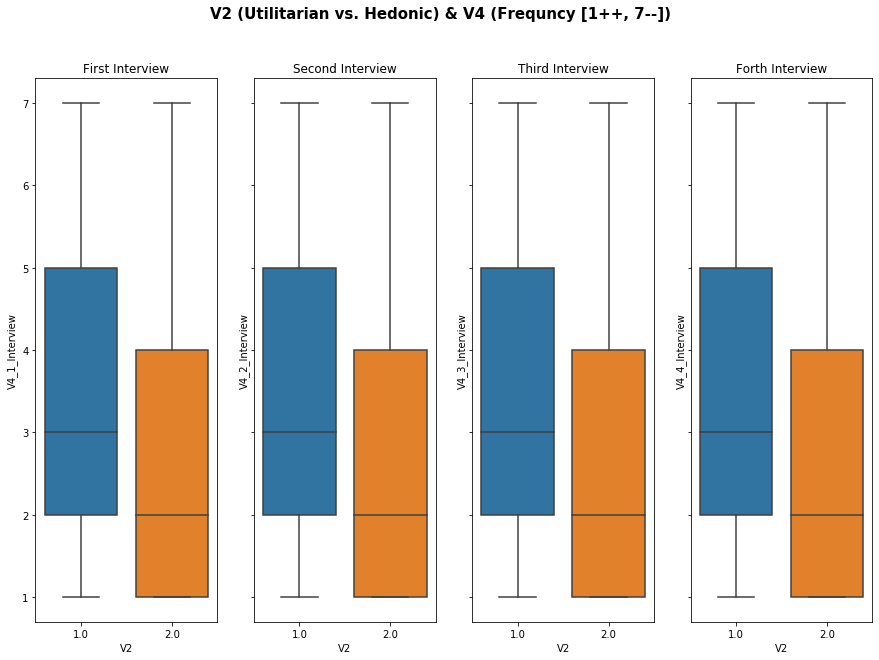

In [3]:
# V2 differences in frequency between utilitarian and hedonic
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True,
                        sharey=True, figsize=(15, 10))
fig.suptitle('V2 (Utilitarian vs. Hedonic) & V4 (Frequncy [1++, 7--])',
             fontsize=15, fontweight='bold')
sns.boxplot(x='V2', y='V4_1_Interview', data=Apps_clean,
            ax=axs[0])
axs[0].set_title('First Interview')
sns.boxplot(x='V2', y='V4_2_Interview', data=Apps_clean,
            ax=axs[1])
axs[1].set_title('Second Interview')
sns.boxplot(x='V2', y='V4_3_Interview', data=Apps_clean,
            ax=axs[2])
axs[2].set_title('Third Interview')
sns.boxplot(x='V2', y='V4_4_Interview', data=Apps_clean,
            ax=axs[3])
axs[3].set_title('Forth Interview')
fig.subplots_adjust(hspace=0.8)
plt.show()


 **COMMENT**: <br />
 - Median across interviews is the same <br />
 - Hedonic apps (2.0) are in average more frequenctly used

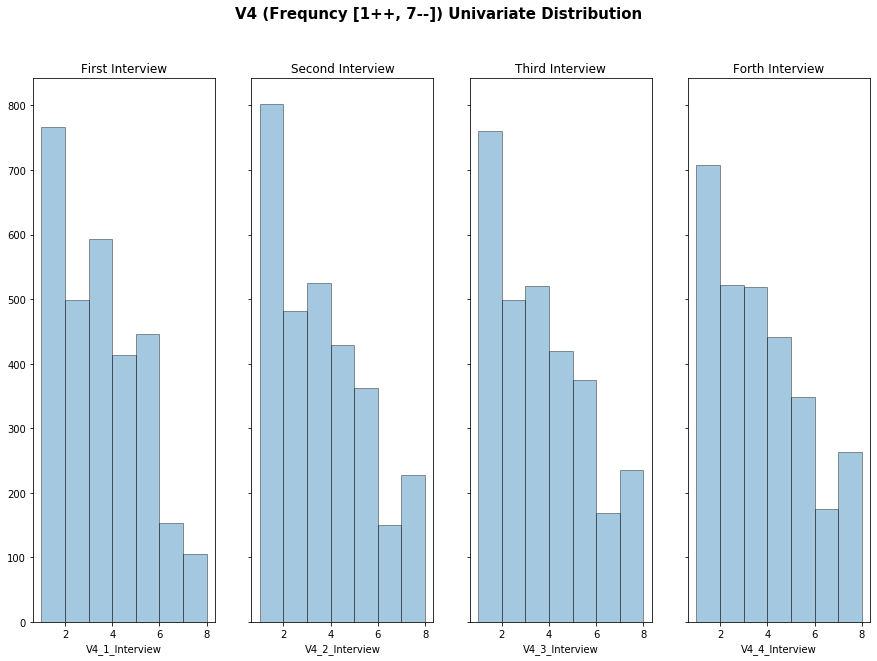

In [4]:
# Dependent variable distribution
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True,
                        sharey=True, figsize=(15, 10))
fig.suptitle('V4 (Frequncy [1++, 7--]) Univariate Distribution',
             fontsize=15, fontweight='bold')
sns.distplot(Apps_clean['V4_1_Interview'], bins=np.arange(1, 9),
             hist_kws=dict(ec="k"), kde=False, ax=axs[0])
axs[0].set_title('First Interview')
sns.distplot(Apps_clean['V4_2_Interview'], bins=np.arange(1, 9),
             hist_kws=dict(ec="k"), kde=False, ax=axs[1])
axs[1].set_title('Second Interview')
sns.distplot(Apps_clean['V4_3_Interview'], bins=np.arange(1, 9),
             hist_kws=dict(ec="k"), kde=False, ax=axs[2])
axs[2].set_title('Third Interview')
sns.distplot(Apps_clean['V4_4_Interview'], bins=np.arange(1, 9),
             hist_kws=dict(ec="k"), kde=False, ax=axs[3])
axs[3].set_title('Forth Interview')
fig.subplots_adjust(hspace=0.8)
plt.show()


 **COMMENT**: <br />
 - The distribution of frequency seems to be the same across interviews

In [5]:
# create a dummy variable
V2_enc = OneHotEncoder(categories='auto', drop='first')
V2_enc = V2_enc.fit(Apps_clean['V2'].values.reshape(-1, 1))
V2_enc.categories_
# 1 if ith apps is hedonic
# 0 if ith apps is utilitarian

X = V2_enc.transform(Apps_clean['V2'].values.reshape(-1, 1)).toarray()

model = stm.OLS(Apps_clean['V4_1_Interview'], stm.add_constant(X)).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         V4_1_Interview   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     174.6
Date:                Tue, 15 Oct 2019   Prob (F-statistic):           8.85e-39
Time:                        10:15:03   Log-Likelihood:                -5755.0
No. Observations:                2977   AIC:                         1.151e+04
Df Residuals:                    2975   BIC:                         1.153e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4372      0.042     81.152      0.0

 *b0* interpreted as the average frequency among utilitarian apps. <br />
 *b0 + b1* average frequency among hendonic apps. <br />
 P-values are very low. This indicates that there is statistical
 evidence of a difference in average frequency between V2
 (utilitarian vs. hedonic apps), but it does not explain variance
 R^2 is low.

In [6]:
# Check if they change with the time.
# (Does not seems to change looking at the graphs)
# run Linear Regression models:
for i in ['V4_1_Interview', 'V4_2_Interview',
          'V4_3_Interview', 'V4_4_Interview']:
    model = stm.OLS(Apps_clean[i], stm.add_constant(X)).fit()
    print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         V4_1_Interview   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     174.6
Date:                Tue, 15 Oct 2019   Prob (F-statistic):           8.85e-39
Time:                        10:15:04   Log-Likelihood:                -5755.0
No. Observations:                2977   AIC:                         1.151e+04
Df Residuals:                    2975   BIC:                         1.153e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4372      0.042     81.152      0.0

 The coefficients does not significantly change across interview

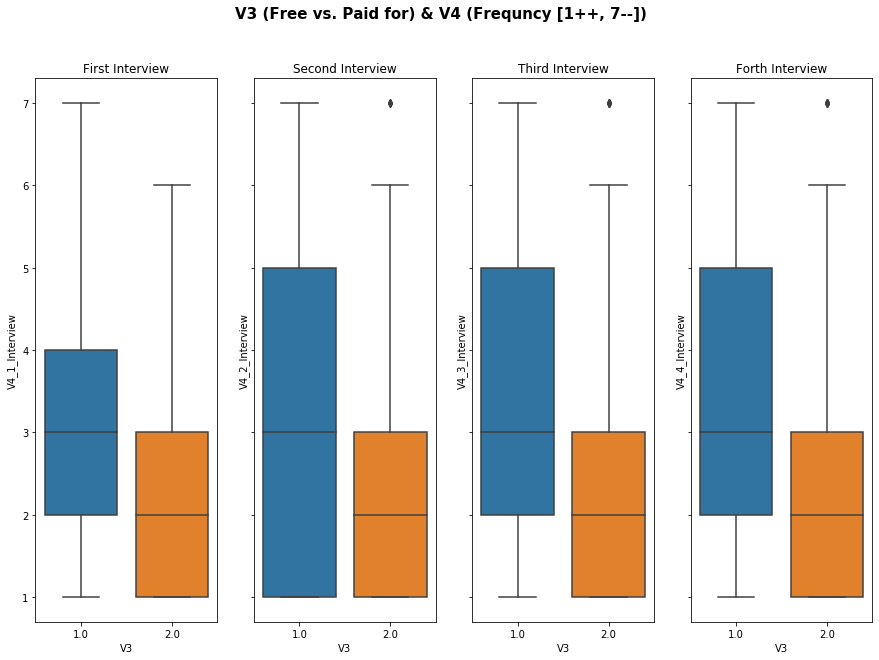

In [7]:
# V3 (free vs paid for)
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True,
                        sharey=True, figsize=(15, 10))
fig.suptitle('V3 (Free vs. Paid for) & V4 (Frequncy [1++, 7--])',
             fontsize=15, fontweight='bold')
sns.boxplot(x='V3', y='V4_1_Interview', data=Apps_clean,
            ax=axs[0])
axs[0].set_title('First Interview')
sns.boxplot(x='V3', y='V4_2_Interview', data=Apps_clean,
            ax=axs[1])
axs[1].set_title('Second Interview')
sns.boxplot(x='V3', y='V4_3_Interview', data=Apps_clean,
            ax=axs[2])
axs[2].set_title('Third Interview')
sns.boxplot(x='V3', y='V4_4_Interview', data=Apps_clean,
            ax=axs[3])
axs[3].set_title('Forth Interview')
fig.subplots_adjust(hspace=0.8)
plt.show()


 1. Median does not change across interviews
 2. Paid for apps (2.0) are more frequently used

In [8]:
# create a dummy variable
V3_enc = OneHotEncoder(categories='auto', drop='first')
V3_enc = V3_enc.fit(Apps_clean['V3'].values.reshape(-1, 1))
V3_enc.categories_
# 1 if ith apps is paid for
# 0 if ith apps is free

del X
X = V3_enc.transform(Apps_clean['V3'].values.reshape(-1, 1)).toarray()

# create the model using statsmodels.api
for i in ['V4_1_Interview', 'V4_2_Interview',
          'V4_3_Interview', 'V4_4_Interview']:
    model = stm.OLS(Apps_clean[i], stm.add_constant(X)).fit()
    print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         V4_1_Interview   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     40.68
Date:                Tue, 15 Oct 2019   Prob (F-statistic):           2.07e-10
Time:                        10:15:05   Log-Likelihood:                -5819.7
No. Observations:                2977   AIC:                         1.164e+04
Df Residuals:                    2975   BIC:                         1.166e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0987      0.032     96.199      0.0

In [9]:
# b0 interpreted as the average frequency among free apps
# b0 + b1 average frequency among paid for apps
# p-value is small so there is statistical evidence of a difference
# in average frequency between V3 (free vs paid for apps).
# The relation does not change with time.


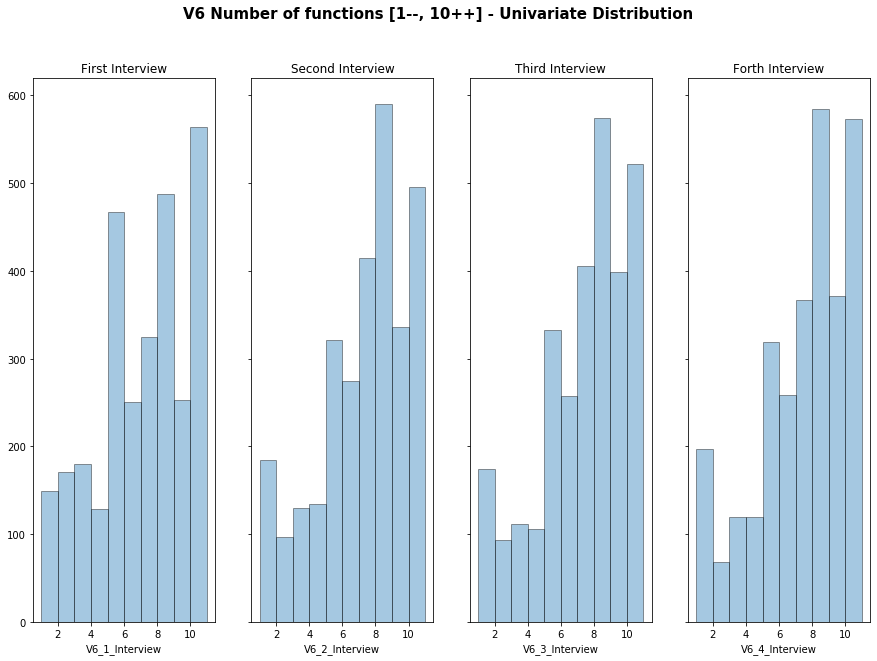

In [10]:
# V6 univariate distribution
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True,
                        sharey=True, figsize=(15, 10))
fig.suptitle('V6 Number of functions [1--, 10++] - Univariate Distribution',
             fontsize=15, fontweight='bold')
sns.distplot(Apps_clean['V6_1_Interview'], bins=np.arange(1, 12),
             hist_kws=dict(ec="k"), kde=False, ax=axs[0])
axs[0].set_title('First Interview')
sns.distplot(Apps_clean['V6_2_Interview'], bins=np.arange(1, 12),
             hist_kws=dict(ec="k"), kde=False, ax=axs[1])
axs[1].set_title('Second Interview')
sns.distplot(Apps_clean['V6_3_Interview'], bins=np.arange(1, 12),
             hist_kws=dict(ec="k"), kde=False, ax=axs[2])
axs[2].set_title('Third Interview')
sns.distplot(Apps_clean['V6_4_Interview'], bins=np.arange(1, 12),
             hist_kws=dict(ec="k"), kde=False, ax=axs[3])
axs[3].set_title('Forth Interview')
fig.subplots_adjust(hspace=0.8)
plt.show()


 V6 distribution does not seems to change across interviews

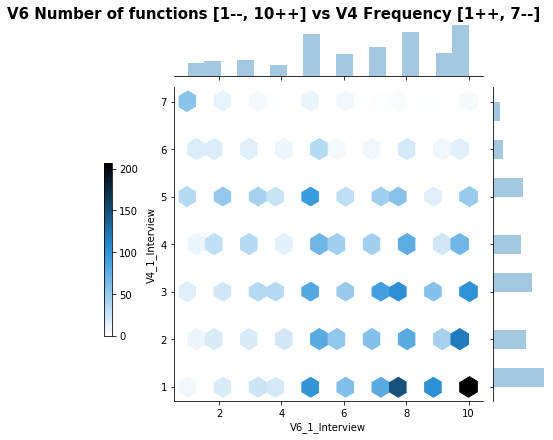

In [11]:
hexplot = sns.jointplot('V6_1_Interview', 'V4_1_Interview', data=Apps_clean,
                        kind='hex')
cbar_ax = hexplot.fig.add_axes([-.05, .25, .02, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.title('V6 Number of functions [1--, 10++] vs V4 Frequency [1++, 7--] ',
          x=20, y=1.8, fontsize=15, fontweight='bold')
plt.show()


 **COMMENT**: <br />
 Apps with more functions tend to be used more.

In [12]:
# create the model using statsmodels.api
model = stm.OLS(Apps_clean.loc[:, 'V4_1_Interview'],
                stm.add_constant(Apps_clean.loc[:, 'V6_1_Interview'])).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         V4_1_Interview   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     436.7
Date:                Tue, 15 Oct 2019   Prob (F-statistic):           1.32e-90
Time:                        10:15:07   Log-Likelihood:                -5636.0
No. Observations:                2977   AIC:                         1.128e+04
Df Residuals:                    2975   BIC:                         1.129e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.5415      0.077     58.

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


 P-value and R-squarred are low: the regression model has significant
 variables but explains little of the variability.
 The trend indicates that the predictor vairable still provides information
 about the response even though data points fall
 further from the regression line.

 Regression between V4 and V10 extended functions

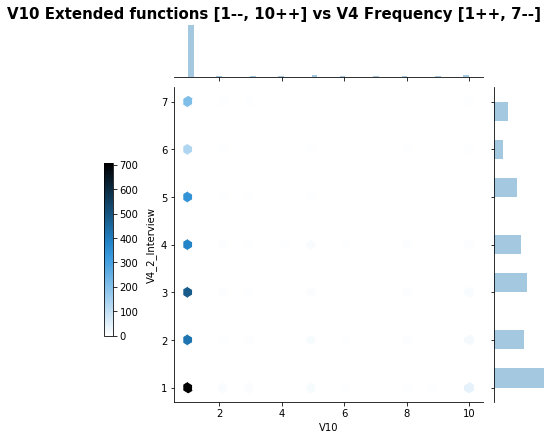

In [13]:
hexplot = sns.jointplot(Apps_clean['V10'], Apps_clean['V4_2_Interview'],
                        kind='hex')
cbar_ax = hexplot.fig.add_axes([-0.05, .25, .02, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.title('V10 Extended functions [1--, 10++] vs V4 Frequency [1++, 7--] ',
          x=20, y=1.8, fontsize=15, fontweight='bold')
plt.show()


 V10 cannot explain variability since almost all in 1. <br />
 feature engineering binarize (always - not always)

 Linear Regression between V4 and V11 cross app use [1--, 10++]

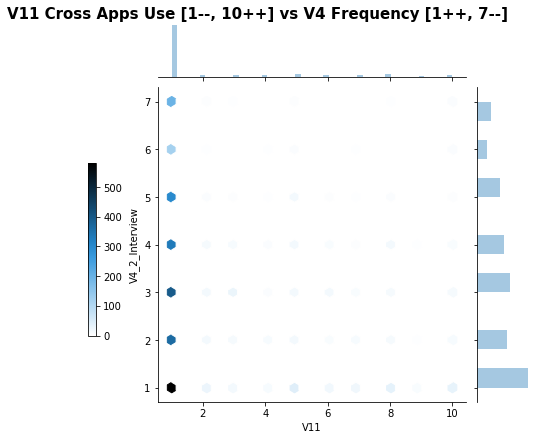

In [14]:
hexplot = sns.jointplot(Apps_clean['V11'], Apps_clean['V4_2_Interview'],
                        kind='hex')
cbar_ax = hexplot.fig.add_axes([-0.05, .25, .02, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.title('V11 Cross Apps Use [1--, 10++] vs V4 Frequency [1++, 7--] ',
          x=20, y=1.8, fontsize=15, fontweight='bold')
plt.show()


 V11 cannot explain variability since almost all in 1. <br />
 feature engineering binarize (always - not always)

 Linear Regression between V4 and V12 Satisfaction [1--, 10++]

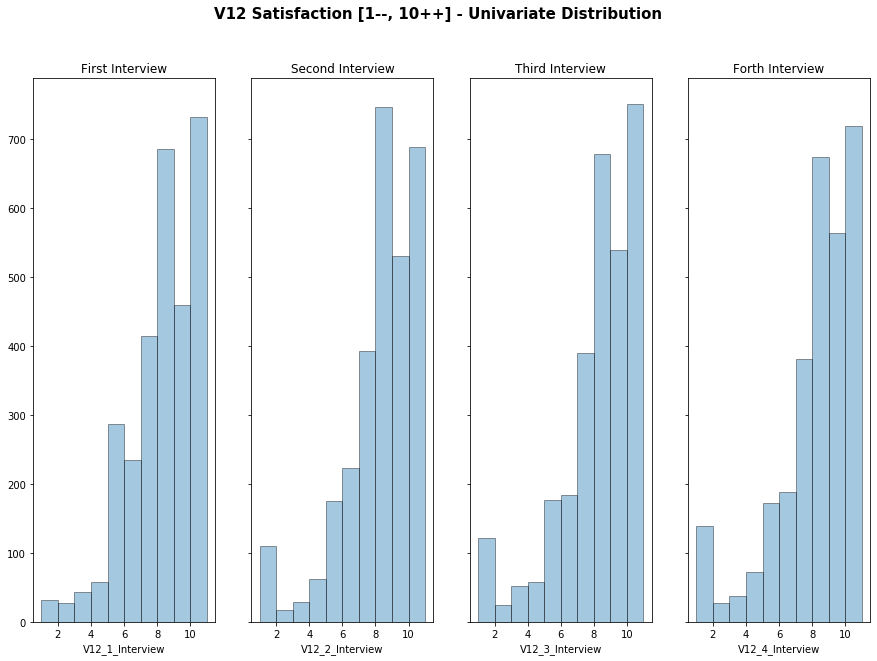

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True,
                        sharey=True, figsize=(15, 10))
fig.suptitle('V12 Satisfaction [1--, 10++] - Univariate Distribution',
             fontsize=15, fontweight='bold')
sns.distplot(Apps_clean['V12_1_Interview'], bins=np.arange(1, 12),
             hist_kws=dict(ec="k"), kde=False, ax=axs[0])
axs[0].set_title('First Interview')
sns.distplot(Apps_clean['V12_2_Interview'], bins=np.arange(1, 12),
             hist_kws=dict(ec="k"), kde=False, ax=axs[1])
axs[1].set_title('Second Interview')
sns.distplot(Apps_clean['V12_3_Interview'], bins=np.arange(1, 12),
             hist_kws=dict(ec="k"), kde=False, ax=axs[2])
axs[2].set_title('Third Interview')
sns.distplot(Apps_clean['V12_4_Interview'], bins=np.arange(1, 12),
             hist_kws=dict(ec="k"), kde=False, ax=axs[3])
axs[3].set_title('Forth Interview')
fig.subplots_adjust(hspace=0.8)
plt.show()


 Distribution doesn't change much with the time

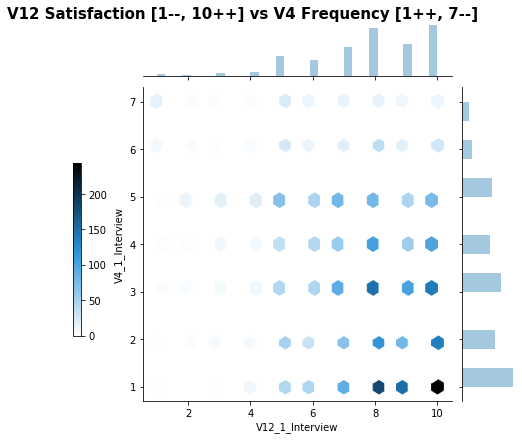

In [16]:
hexplot = sns.jointplot(Apps_clean['V12_1_Interview'],
                        Apps_clean['V4_1_Interview'], kind='hex')
cbar_ax = hexplot.fig.add_axes([-0.05, .25, .02, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.title('V12 Satisfaction [1--, 10++] vs V4 Frequency [1++, 7--] ',
          x=20, y=1.8, fontsize=15, fontweight='bold')
plt.show()


In [17]:
# create the model using statsmodels.api
model = stm.OLS(Apps_clean.loc[:, 'V4_1_Interview'],
                stm.add_constant(Apps_clean.loc[:, 'V12_1_Interview'])).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         V4_1_Interview   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     236.5
Date:                Tue, 15 Oct 2019   Prob (F-statistic):           2.04e-51
Time:                        10:15:11   Log-Likelihood:                -5726.0
No. Observations:                2977   AIC:                         1.146e+04
Df Residuals:                    2975   BIC:                         1.147e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.8784      0.123     

 **COMMENTS**:<br />
 - Statistic evidence different means
 - Don't change over time (look distribution)
 - People more satisfy tend to use the app moren

 Linear Regression between V4 and V13 Future use \[1--, 10++\]

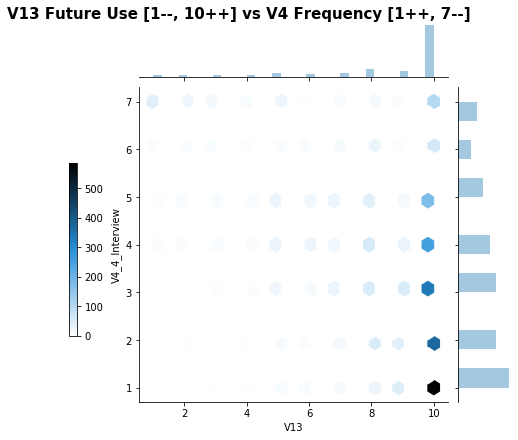

In [18]:
pd.value_counts(Apps_clean['V13'])
hexplot = sns.jointplot(Apps_clean['V13'], Apps_clean['V4_4_Interview'],
                        kind='hex')
cbar_ax = hexplot.fig.add_axes([-0.05, .25, .02, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.title('V13 Future Use [1--, 10++] vs V4 Frequency [1++, 7--] ',
          x=20, y=1.8, fontsize=15, fontweight='bold')
plt.show()


 High 10s in V3

In [19]:
# create the model using statsmodels.api
model = stm.OLS(Apps_clean.loc[:, 'V4_1_Interview'],
                stm.add_constant(Apps_clean.loc[:, 'V13'])).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         V4_1_Interview   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     1123.
Date:                Tue, 15 Oct 2019   Prob (F-statistic):          3.46e-209
Time:                        10:15:12   Log-Likelihood:                -5363.1
No. Observations:                2977   AIC:                         1.073e+04
Df Residuals:                    2975   BIC:                         1.074e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3954      0.103     61.881      0.0

 **COMMENT**: <br />
 - Statistic evidence different means <br />
 - More future use tend to use the app more

 Linear Regression between V4 and V14 recommendation \[1--,10++\]

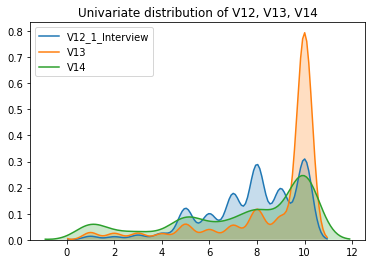

In [20]:
sns.kdeplot(Apps_clean['V12_1_Interview'], shade=True)
sns.kdeplot(Apps_clean['V13'], shade=True)
sns.kdeplot(Apps_clean['V14'], shade=True)
plt.title('Univariate distribution of V12, V13, V14')
plt.show()


 **COMMENT**: <br />
 Univariate distribution shows higher values for V12, V13, V14
 with a weaker effect for V14

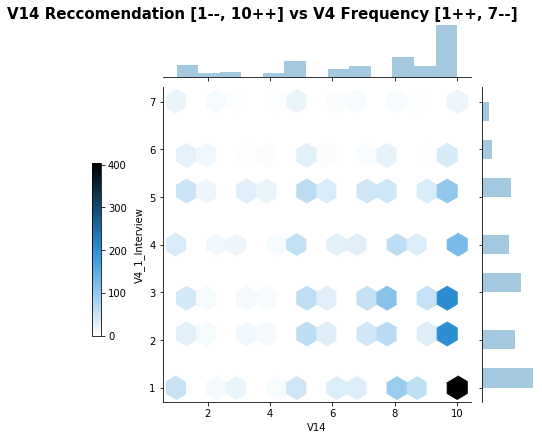

In [21]:
# So I expect the same behaviour of V12, V13, V14
# Joint probability distribution
hexplot = sns.jointplot(Apps_clean['V14'], Apps_clean['V4_1_Interview'],
                        kind='hex')
cbar_ax = hexplot.fig.add_axes([-0.05, .25, .02, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
plt.title('V14 Reccomendation [1--, 10++] vs V4 Frequency [1++, 7--] ',
          x=20, y=1.8, fontsize=15, fontweight='bold')
plt.show()


 Higher values indicates more frequently used apps.

In [22]:
# create the model using statsmodels.api
model = stm.OLS(Apps_clean.loc[:, 'V4_1_Interview'],
                stm.add_constant(Apps_clean.loc[:, 'V14'])).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         V4_1_Interview   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     196.4
Date:                Tue, 15 Oct 2019   Prob (F-statistic):           2.87e-43
Time:                        10:15:13   Log-Likelihood:                -5744.7
No. Observations:                2977   AIC:                         1.149e+04
Df Residuals:                    2975   BIC:                         1.151e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1013      0.081     50.682      0.0

 There is statistic evidence different means
 Higher recommendation brings higher use frequency

 ### CORRELATION MAP

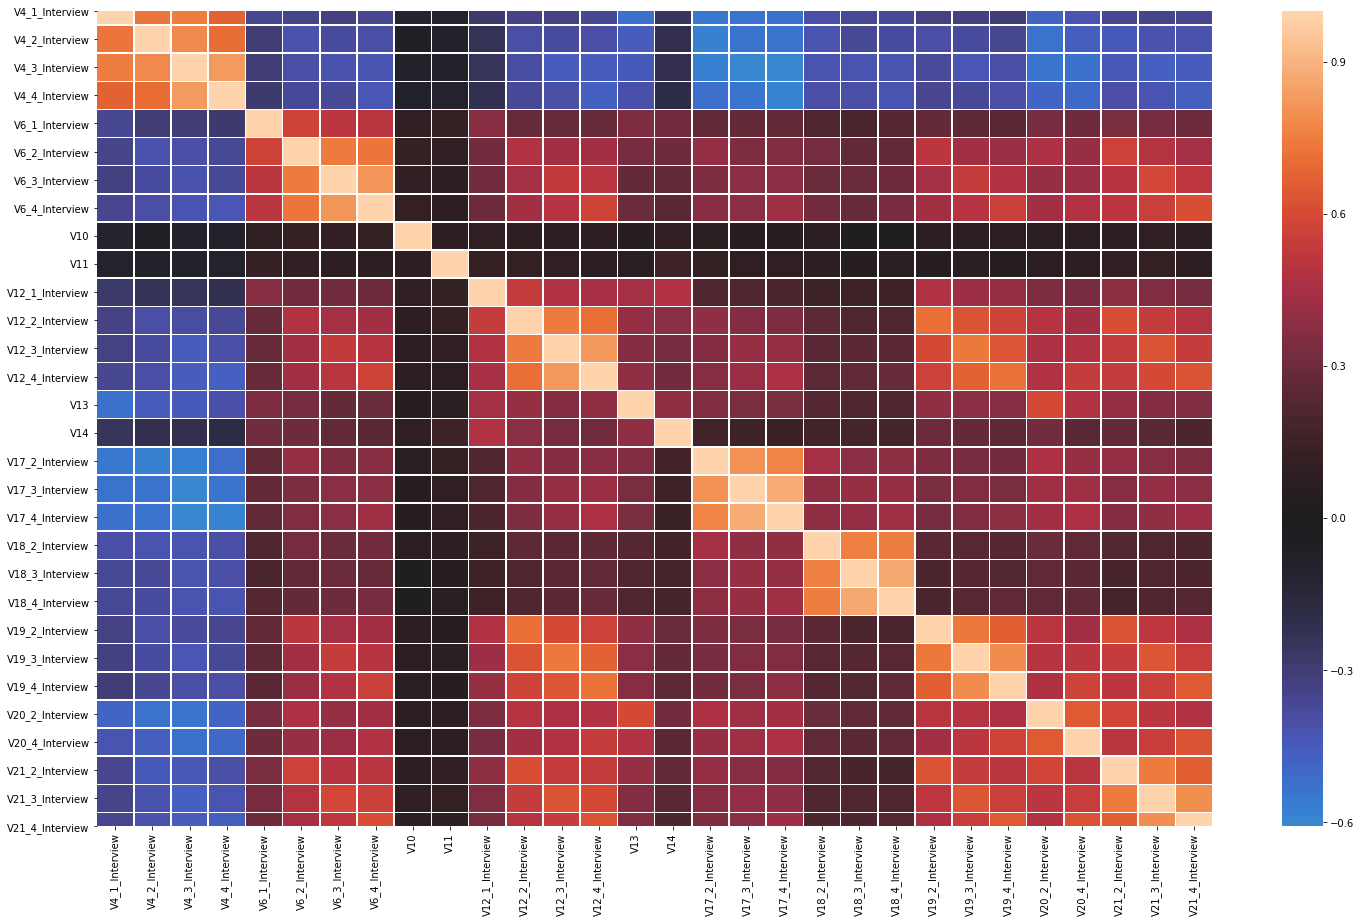

In [23]:
# index, identifiers and categorical variables
X = Apps_clean.drop(['Probanden_ID__lfdn__AppNr',
                     'Probanden_ID__lfdn',
                     'Datum_1_Interview', 'Datum_2_Interview',
                     'Datum_3_Interview',
                     'Datum_4_Interview', 'V1', 'V01', 'V2', 'V3',
                     'Miss_row_%', 'Days_Between_2_and_1_Interview',
                     'Days_Between_3_and_2_Interview',
                     'Days_Between_4_and_3_Interview'], axis=1)
corr = X.corr()

fig, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(corr, center=0, linewidths=0.5)
plt.show()


 **COMMENT**:<br />
 V17, V18, V19, V20, V21 show positive correlation between the
 dependent variables and negative correlation with V4.
 V18 weaker than other.

 ## 2. MODELLING
 Multi variate statistics and mediation relationship

 #### Check assumptions that observations are time independent

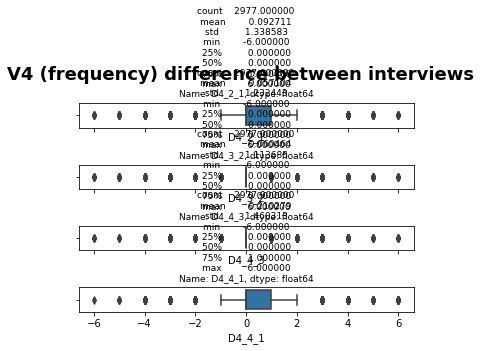

In [24]:
# V4
Apps_clean.loc[:, 'D4_2_1'] = Apps_clean.loc[:, 'V4_2_Interview'] - \
                              Apps_clean.loc[:, 'V4_1_Interview']
Apps_clean.loc[:, 'D4_3_2'] = Apps_clean.loc[:, 'V4_3_Interview'] - \
                              Apps_clean.loc[:, 'V4_2_Interview']
Apps_clean.loc[:, 'D4_4_3'] = Apps_clean.loc[:, 'V4_4_Interview'] - \
                              Apps_clean.loc[:, 'V4_3_Interview']
Apps_clean.loc[:, 'D4_4_1'] = Apps_clean.loc[:, 'V4_4_Interview'] - \
                              Apps_clean.loc[:, 'V4_1_Interview']

fig, axs = plt.subplots(4, sharex=True, sharey=True)
fig.suptitle('V4 (frequency) difference between interviews',
             fontsize=18, fontweight='bold')
sns.boxplot(Apps_clean['D4_2_1'], ax=axs[0])
axs[0].set_title('{}'.format(pd.DataFrame.describe(Apps_clean['D4_2_1'])),
                 fontsize=9)
sns.boxplot(Apps_clean['D4_3_2'], ax=axs[1])
axs[1].set_title('{}'.format(pd.DataFrame.describe(Apps_clean['D4_3_2'])),
                 fontsize=9)
sns.boxplot(Apps_clean['D4_4_3'], ax=axs[2])
axs[2].set_title('{}'.format(pd.DataFrame.describe(Apps_clean['D4_4_3'])),
                 fontsize=9)
sns.boxplot(Apps_clean['D4_4_1'], ax=axs[3])
axs[3].set_title('{}'.format(pd.DataFrame.describe(Apps_clean['D4_4_1'])),
                 fontsize=9)
fig.subplots_adjust(top=0.85, hspace=1.5)
plt.show()


 **COMMENTS**: <br />
 Most of the observations 50% didn't change with time
 Biggest differences bewteen the second and first interview where
 the frequency of 20% obs is increased by 1.

In [0]:
fig, axs = plt.subplots(nrows=1, ncols=4, sharex=True,
                        sharey=True, figsize=(15, 10))
fig.suptitle('V4 Difference - Univariate Distribution',
             fontsize=15, fontweight='bold')
sns.distplot(Apps_clean['D4_2_1'], bins=np.arange(-6, 7),
             hist_kws=dict(ec="k"), kde=False, ax=axs[0])
axs[0].set_title('V4 difference between 2 and 1 interview', fontsize=8)
sns.distplot(Apps_clean['D4_3_2'], bins=np.arange(-6, 7),
             hist_kws=dict(ec="k"), kde=False, ax=axs[1])
axs[1].set_title('V4 difference between 3 and 2 interview', fontsize=8)
sns.distplot(Apps_clean['D4_4_3'], bins=np.arange(-6, 7),
             hist_kws=dict(ec="k"), kde=False, ax=axs[2])
axs[2].set_title('V4 difference between 4 and 3 interview', fontsize=8)
sns.distplot(Apps_clean['D4_4_1'], bins=np.arange(-6, 7),
             hist_kws=dict(ec="k"), kde=False, ax=axs[3])
axs[3].set_title('V4 difference between 4 and 1 interview', fontsize=8)
fig.subplots_adjust(hspace=0.8)
plt.show()


In [0]:
# V6
Apps_clean['D6_2_1'] = Apps_clean['V6_2_Interview'] - \
                       Apps_clean['V6_1_Interview']
Apps_clean['D6_3_2'] = Apps_clean['V6_3_Interview'] - \
                       Apps_clean['V6_2_Interview']
Apps_clean['D6_4_3'] = Apps_clean['V6_4_Interview'] - \
                       Apps_clean['V6_3_Interview']
Apps_clean['D6_4_1'] = Apps_clean['V6_4_Interview'] - \
                       Apps_clean['V6_1_Interview']

fig, axs = plt.subplots(4, sharex=True, sharey=True)
fig.suptitle('V6 (function) difference between interviews',
             fontsize=18, fontweight='bold')
sns.boxplot(Apps_clean['D6_2_1'], ax=axs[0])
axs[0].set_title('{}'.format(pd.DataFrame.describe(Apps_clean['D6_2_1'])),
                 fontsize=9)
sns.boxplot(Apps_clean['D6_3_2'], ax=axs[1])
axs[1].set_title('{}'.format(pd.DataFrame.describe(Apps_clean['D6_3_2'])),
                 fontsize=9)
sns.boxplot(Apps_clean['D6_4_3'], ax=axs[2])
axs[2].set_title('{}'.format(pd.DataFrame.describe(Apps_clean['D6_4_3'])),
                 fontsize=9)
sns.boxplot(Apps_clean['D6_4_1'], ax=axs[3])
axs[3].set_title('{}'.format(pd.DataFrame.describe(Apps_clean['D6_4_1'])),
                 fontsize=9)
fig.subplots_adjust(top=0.85, hspace=1.5)
plt.show()


 **COMMENTS**: <br />
 Most of the observations didn't change with the time.
 Biggest difference are within the 2 and 3 interview.
 In the second interview 20% observations increase frequency by 1
 and another 20% decrease by 1.
 In the third inteview 20% observation increase by 1.
 This accumulative effect is incorporate in D6_4_1.

In [0]:
# V12
Apps_clean['D12_2_1'] = Apps_clean['V12_2_Interview'] - \
                       Apps_clean['V12_1_Interview']
Apps_clean['D12_3_2'] = Apps_clean['V12_3_Interview'] - \
                       Apps_clean['V12_2_Interview']
Apps_clean['D12_4_3'] = Apps_clean['V12_4_Interview'] - \
                       Apps_clean['V12_3_Interview']
Apps_clean['D12_4_1'] = Apps_clean['V12_4_Interview'] - \
                       Apps_clean['V12_1_Interview']

fig, axs = plt.subplots(4, sharex=True, sharey=True)
fig.suptitle('V12 (satisfaction) difference between interviews',
             fontsize=18, fontweight='bold')
sns.boxplot(Apps_clean['D12_2_1'], ax=axs[0])
axs[0].set_title('{}'.format(pd.DataFrame.describe(Apps_clean['D12_2_1'])),
                 fontsize=9)
sns.boxplot(Apps_clean['D12_3_2'], ax=axs[1])
axs[1].set_title('{}'.format(pd.DataFrame.describe(Apps_clean['D12_3_2'])),
                 fontsize=9)
sns.boxplot(Apps_clean['D12_4_3'], ax=axs[2])
axs[2].set_title('{}'.format(pd.DataFrame.describe(Apps_clean['D12_4_3'])),
                 fontsize=9)
sns.boxplot(Apps_clean['D12_4_1'], ax=axs[3])
axs[3].set_title('{}'.format(pd.DataFrame.describe(Apps_clean['D12_4_1'])),
                 fontsize=9)
fig.subplots_adjust(top=0.85, hspace=1.5)
plt.show()


 **COMMENT**: <br />
 There are some "level off" effects.
 Investigate further the relationship (TODO)

 #### MODEL 1a: V6_1, V2 ---> V4_1
 **STEP** **1**: V6_1 on V4_1

In [0]:
# Model V6 on V4 at the starting point, during the interview 1
# (since first interview good baseline since 50% of observation
# does not change in the following interviews)
# Mediating for V2 using simple mediation model by Baron and Kenny's
model1 = stm.OLS(Apps_clean.loc[:, 'V4_1_Interview'],
                 stm.add_constant(Apps_clean.loc[:, 'V6_1_Interview'])).fit()
print(model1.summary())


 **COMMENT**: <br />
 *V6_1* coef is significant one unit in increase of functionality
 brings -0.2277 decrease in frequency (Remember with frequency less is more)
 (TODO) consider to invert Frequency so it is more intuitive

 **STEP** **2**: V6_1 on V2

In [0]:
# Check mediator effect
# Create dummy variable for V2
V2 = V2_enc.transform(Apps_clean.loc[:, 'V2'].values.reshape(-1, 1)).toarray()
# 1 if ith apps is hedonic
# 0 if ith apps is utilitarian

logit2 = stm.Logit(V2, stm.add_constant(Apps_clean.
                                        loc[:, 'V6_1_Interview'])).fit()
print(logit2.summary())


 **COMMENT**: <br />
 *V6_1_Interview* is significant with p = 0.009. <br />
 The intercept is the estimated log odds (log(p/1-p)) of an app with a number
 of functions (*V6*) of zero being an hedonic apps (*V2*).<br />
 The conditional logit of being an hedonic app when the number of functions
 is held to 5: $b0 + b1*V6 >> -0,3297 + (0,0356*5)$<br />
 For 1 unit increase in the number function, the expected change in the log
 odds of being an hedonic app is $b1 = 0,0356§.

 **STEP** **3**: V6_1, V2 ---> V4_1

In [0]:
del X
X = np.hstack([Apps_clean['V6_1_Interview'].values.reshape(-1, 1), V2])

model3 = stm.OLS(Apps_clean.loc[:, 'V4_1_Interview'],
                 stm.add_constant(X)).fit()
print(model3.summary())


 Coefs are all significant --> Partial mediation

In [0]:
# Direct effect of number of functions on frequency
model1.params[1]

In [0]:
# Indirect effect
logit2.params[1]*model3.params[2]

In [0]:
# Partial mediation coef V6 on step 1 greater then coef V6 step 3
abs(model1.params[1]) > abs(model3.params[1])

In [0]:
# Total effect
model3.params[1] + (logit2.params[1]*model3.params[2])


In [0]:
# Using mediation model in stasmodels (Imai, Keele, Tingley (2010))
# Regression model for the outcome
Apps_clean['V2'] = V3_enc.transform(Apps_clean['V2'].
                                    values.reshape(-1, 1)).toarray()

outcome_model = stm.OLS.from_formula('V4_1_Interview ~ V6_1_Interview + \
                                     V2',
                                     data=Apps_clean)

# Regression model for the mediator variable
mediator_model = stm.GLM.from_formula('V2 ~ V6_1_Interview ',
                                      data=Apps_clean,
                                      family=stm.families.Binomial())

med = Mediation(outcome_model, mediator_model, 'V6_1_Interview', 'V2')

med_result = med.fit()

med_result.summary()


 **COMMENT**:<br />
 The *ACME* (Average Causal Mediation Effect) is not statistically
 distinct from zero.

 #### Model 1b: D6_4_1, V2 ---> D4_4_1 <br />
 Model the difference in number of functions (*V6*) onto the
 difference in frequency (*V4*) mediating for *V2*.
 (Since differences within interviews seems to be commulative,
 thus changes does not seems to level out >> check further on outliers
 to spot trends within time. TODO)

 **STEP** **1**: D6_4_1 on D4_4_1

In [0]:
model1 = stm.OLS(Apps_clean.loc[:, 'D4_4_1'],
                 stm.add_constant(Apps_clean.loc[:, 'D6_4_1'])).fit()
print(model1.summary())


 **COMMENT**:<br />
 Statistical evidence means between *D4_4_1* and *D6_4_1*. <br />
 Increments of function reduce frequency values,
 which translate that the apps is used more (and viceversa)

 **STEP** **2**: D6_4_1 on V2

In [0]:
# Check mediator effect

logit2 = stm.Logit(V2, stm.add_constant(Apps_clean.
                                        loc[:, 'D6_4_1'])).fit()
# 1 if ith apps is hedonic
# 0 if ith apps is utilitarian
print(logit2.summary())


 **COMMENT**: <br />
 With a $p-value = 0,119$ we fail to reject the null hypothesis.
 Since *D6_4_1* is not significant, it cannot mediate anything.

 #### MODEL 2a
 **STEP** **1**: V6_1, V12_1, V2, V3 ---> V4_1

In [0]:
del X
V3 = V3_enc.transform(Apps_clean['V3'].values.reshape(-1, 1)).toarray()
X = np.hstack([Apps_clean.loc[:, 'V6_1_Interview'].values.reshape(-1, 1),
              Apps_clean.loc[:, 'V12_1_Interview'].values.reshape(-1, 1),
              V2, V3])

model1 = stm.OLS(Apps_clean.loc[:, 'V4_1_Interview'],
                 stm.add_constant(X)).fit()
print(model1.summary())


 **COMMENT**: <br />
 Coefs are all statisticaly significant.
 *V3* lower significance (information already covered by V2).

 **STEP** **2**: mediation effects. <br />
 Reference Imai, Keele, Tingley (2010)

In [0]:
Apps_clean['V3'] = V3_enc.transform(Apps_clean['V3'].
                                    values.reshape(-1, 1)).toarray()

# V6*V2
# Regression model for the outcome
outcome_model = stm.OLS.from_formula('V4_1_Interview ~ V6_1_Interview + \
                                     V12_1_Interview + V3 + V2',
                                     data=Apps_clean)

# Regression model for the mediator variable
mediator_model = stm.GLM.from_formula('V2 ~ V6_1_Interview + \
                                       V12_1_Interview + V3',
                                      data=Apps_clean,
                                      family=stm.families.Binomial())

med = Mediation(outcome_model, mediator_model, 'V6_1_Interview', 'V2')

med_result = med.fit()

med_result.summary()


 **COMMENT**: <br />
 *ACME* (Average Causal Mediation Effect). <br />
 *ADE* (Average Direct Effect). <br />
 The results above demonstrate that the ACME is not statistically distinct
 from zero, or no mediation. The average direct effect (ADE) is negative
 and statistically notable. The total effect is statistically notable and it
 is driven by ADE.

In [0]:
# V12 * V2
# Regression model for the outcome
outcome_model = stm.OLS.from_formula('V4_1_Interview ~ V6_1_Interview + \
                                     V12_1_Interview + V3 + V2',
                                     data=Apps_clean)

# Regression model for the mediator variable
mediator_model = stm.GLM.from_formula('V2 ~ V6_1_Interview + \
                                       V12_1_Interview + V3',
                                      data=Apps_clean,
                                      family=stm.families.Binomial())

med = Mediation(outcome_model, mediator_model, 'V12_1_Interview', 'V2')
med_result = med.fit()
med_result.summary()


 **COMMENT**: <br />
 Only direct effect is statistically significant

In [0]:
# V6 * V3
# Regression model for the outcome
outcome_model = stm.OLS.from_formula('V4_1_Interview ~ V6_1_Interview + \
                                     V12_1_Interview + V3 + V2',
                                     data=Apps_clean)

# Regression model for the mediator variable
mediator_model = stm.GLM.from_formula('V3 ~ V6_1_Interview + \
                                       V12_1_Interview + V2',
                                      data=Apps_clean,
                                      family=stm.families.Binomial())

med = Mediation(outcome_model, mediator_model, 'V12_1_Interview', 'V3')
med_result = med.fit()
med_result.summary()


 **COMMENT**: <br />
 Only direct effect is significant

In [0]:
# V12 * V3
# Regression model for the outcome
outcome_model = stm.OLS.from_formula('V4_1_Interview ~ V6_1_Interview + \
                                     V12_1_Interview + V3 + V2',
                                     data=Apps_clean)

# Regression model for the mediator variable
mediator_model = stm.GLM.from_formula('V3 ~ V6_1_Interview + \
                                       V12_1_Interview + V2',
                                      data=Apps_clean,
                                      family=stm.families.Binomial())

med = Mediation(outcome_model, mediator_model, 'V12_1_Interview', 'V3')
med_result = med.fit()
med_result.summary()


 **COMMENT**: <br />
 Only Average Direct Effect statistically significant

In [0]:
# V2 * V3
# Regression model for the outcome
outcome_model = stm.OLS.from_formula('V4_1_Interview ~ V6_1_Interview + \
                                     V12_1_Interview + V3 + V2',
                                     data=Apps_clean)

# Regression model for the mediator variable
mediator_model = stm.GLM.from_formula('V3 ~ V6_1_Interview + \
                                       V12_1_Interview + V2',
                                      data=Apps_clean,
                                      family=stm.families.Binomial())

med = Mediation(outcome_model, mediator_model, 'V2', 'V3')
med_result = med.fit()
med_result.summary()


 **COMMENT**: <br />
 With a $p-value = 0.014$ also the Average Causal Mediation Effect is
 statistically significant.

In [0]:
# V6 * V12
# Regression model for the outcome
outcome_model = stm.OLS.from_formula('V4_1_Interview ~ V6_1_Interview + \
                                     V12_1_Interview + V3 + V2',
                                     data=Apps_clean)

# Regression model for the mediator variable
mediator_model = stm.OLS.from_formula('V12_1_Interview ~ V6_1_Interview + \
                                       V3 + V2',
                                      data=Apps_clean)

med = Mediation(outcome_model, mediator_model, 'V6_1_Interview',
                'V12_1_Interview')
med_result = med.fit()
med_result.summary()


 **COMMENT**:<br />
 With a $p-value=0.0$ the Average Direct Effect and the Average Causal
 Mediation Effect are both statistically significant

 #### MODEL 2b: A modereted mediation analysis<br />

In [0]:
# Add novelty seeking.
clean_NS = pd.merge(Apps_clean, Personality.loc[:, ['Probanden_ID__lfdn',
                                                    'NovSeek']],
                    on='Probanden_ID__lfdn')

# NovSeek avereage between [1--, 10++]
pd.DataFrame.describe(clean_NS['NovSeek'])


In [0]:
# The midiation effect is computed for people with high novelty seeking
# V6*V2
# Regression model for the outcome
outcome_model = stm.OLS.from_formula('V4_1_Interview ~ V6_1_Interview*NovSeek \
                                     + V12_1_Interview + V3 + V2*NovSeek',
                                     data=clean_NS)

# Regression model for the mediator variable
mediator_model = stm.GLM.from_formula('V2 ~ V6_1_Interview*NovSeek + \
                                       V12_1_Interview + V3',
                                      data=clean_NS,
                                      family=stm.families.Binomial())
moderators = {'NovSeek': 10}
med = Mediation(outcome_model, mediator_model, 'V6_1_Interview', 'V2',
                moderators=moderators).fit()
med.summary()


 **COMMENT**: <br />
 Only direct effect is significant

In [0]:
outcome_model = stm.OLS.from_formula('V4_1_Interview ~ V6_1_Interview + \
                                     V12_1_Interview + V3 + V2 + NovSeek',
                                     data=clean_NS)

# Regression model for the mediator variable
mediator_model = stm.OLS.from_formula('NovSeek ~ V6_1_Interview + \
                                       V12_1_Interview + V3 + V2',
                                      data=clean_NS)

med = Mediation(outcome_model, mediator_model, 'V6_1_Interview',
                'NovSeek').fit()
med.summary()


 **COMMENT**: <br />
 Only direct effect is significant.

In [0]:
# #### Missing Values Analysis


In [0]:
Apps_missing = Apps.drop(list(Apps_clean.index))

# Difference in V6 for the missing and clean dataset
V6_clean_1 = pd.DataFrame.describe(Apps_clean['V6_1_Interview'])
V6_miss_1 = pd.DataFrame.describe(Apps_missing['V6_1_Interview'])

fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(15, 10))
fig.suptitle('V6 (frequency) within clean and missing observations',
             fontsize=15, fontweight='bold')
sns.boxplot(Apps_clean['V6_1_Interview'], ax=axs[0])
axs[0].set_title('{}'.format(V6_clean_1), fontsize=9, fontweight='bold')
sns.boxplot(Apps_missing['V6_1_Interview'], ax=axs[1])
axs[1].set_title('{}'.format(V6_miss_1), fontsize=9, fontweight='bold')
fig.subplots_adjust(top=0.85, hspace=0.8)
plt.show()


In [0]:
# Difference in V12 for the missing and clean dataset
V12_clean_1 = pd.DataFrame.describe(Apps_clean['V12_1_Interview'])
V12_miss_1 = pd.DataFrame.describe(Apps_missing['V12_1_Interview'])

fig, axs = plt.subplots(2, sharex=True, sharey=True, figsize=(15, 10))
fig.suptitle('V12 (satisfaction) within clean and missing observations',
             fontsize=15, fontweight='bold')
sns.boxplot(Apps_clean['V12_1_Interview'], ax=axs[0])
axs[0].set_title('{}'.format(V12_clean_1), fontsize=9, fontweight='bold')
sns.boxplot(Apps_missing['V12_1_Interview'], ax=axs[1])
axs[1].set_title('{}'.format(V12_miss_1), fontsize=9, fontweight='bold')
fig.subplots_adjust(top=0.85, hspace=0.8)
plt.show()


 **COMMENT**: <br />
 No difference between the two datasets.